## Autoencoder Model Imports

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

2023-05-29 16:12:10.049107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EdgeConnect Model Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F

## Load Models

#### Autoencoder

In [3]:
@keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [4]:
with open('AE_model_256.pkl', 'rb') as f:
    AE_model = pickle.load(f)

with open('AE_model_hist_256.pkl','rb') as f:
    AE_history = pickle.load(f)

2023-05-29 16:12:15.390011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:12:15.391294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:12:15.391564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:12:15.393020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:12:15.393322: I tensorflow/compile

#### EdgeConnect

In [5]:
# Define the EdgeConnect model
class EdgeConnect(nn.Module):
    def __init__(self):
        super(EdgeConnect, self).__init__()
        self.edge_model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),  # Input: 4 channels (img + mask), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.completion_model = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=5, padding=2),  # Input: 5 channels (img + mask + edges), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 3, kernel_size=5, padding=2),  # Output: 3 channels (RGB image)
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        edges = self.edge_model(x)  # Forward pass through the edge model

        # Upsample 'edges' to match the spatial dimensions of 'x'
        edges_upsampled = F.interpolate(edges, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)

        # Concatenate 'x' and the upsampled 'edges'
        completion = self.completion_model(torch.cat([x, edges_upsampled], dim=1))  
        return edges, completion

In [6]:
# Create an instance of the EdgeConnect model
model = EdgeConnect()
# Load the saved model checkpoint
model.load_state_dict(torch.load('EdgeConnect.pth'))


<All keys matched successfully>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EdgeConnect(
  (edge_model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Sigmoid()
  )
  (completion_model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05

## Load Test Data

In [8]:
image_directory = './data/test/matching_images'

# Get the list of image file names
image_files = os.listdir(image_directory)

# Load the images and assign labels manually
x_test = []
y_test = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_directory, filename)
    image = keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image_array = keras.preprocessing.image.img_to_array(image).astype('uint8')  # Convert to uint8
    
    # Add the image to the training data
    x_test.append(image_array)
    
    # Assign a label based on the filename or any other criteria
    # Modify this part according to your labeling requirements
    y_test.append(filename[0])

# Convert the lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)

x_test shape: (72, 256, 256, 3)
72 test samples
y_test shape: (72,)


## Define helper functions

In [9]:
def mask_image(img):
    ## Prepare masking matrix
    mask = np.full((256,256,3), 255, np.uint8)
    mask_only = np.full_like(img, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
        # Get random x locations to start line
        x1, x2 = np.random.randint(1, 256), np.random.randint(1, 256)
        # Get random y locations to start line
        y1, y2 = np.random.randint(1, 256), np.random.randint(1, 256)
        # Get random thickness of the line drawn
        thickness = np.random.randint(8, 16)
        # Draw black line on the white mask
        cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)
        cv2.line(mask_only, (x1, y1), (x2, y2), (0, 0, 0), thickness)

    # Perform bitwise and operation to make the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image/255, cv2.bitwise_not(mask_only)

In [10]:
def plot_results(history, model_name):
    #plot training and test loss for each epoch, and plot test accuracy
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(model_name+' Training History')
    history=history.history
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.plot(range(epochs), history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['val_dice_coef'], label='Val Dice Coef')
    plt.plot(range(epochs),history['dice_coef'],label='Train Dice Coef')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coef')
    plt.legend()
    
    return plt

## Plot loss functions

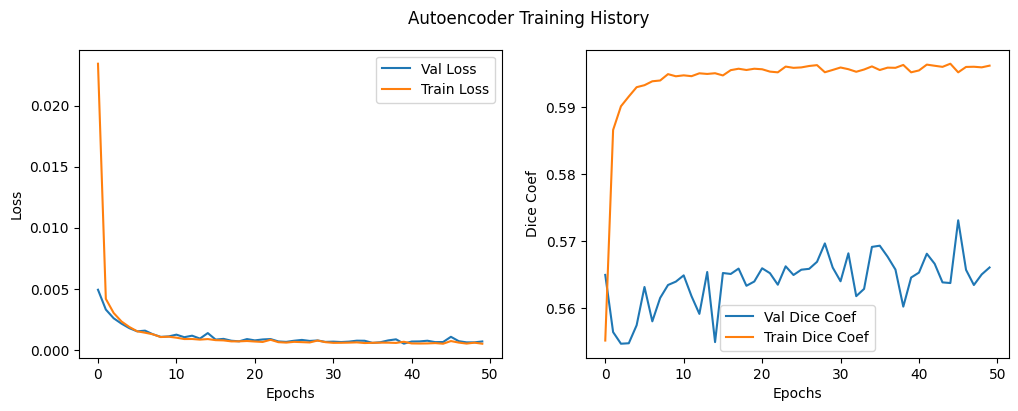

Final Dice Coef: 0.573093593120575


In [11]:
plot_results(AE_history,'Autoencoder').show()
print("Final Dice Coef: " + str(max(AE_history.history['val_dice_coef'])))

## Plot example images

2023-05-29 16:12:43.729743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


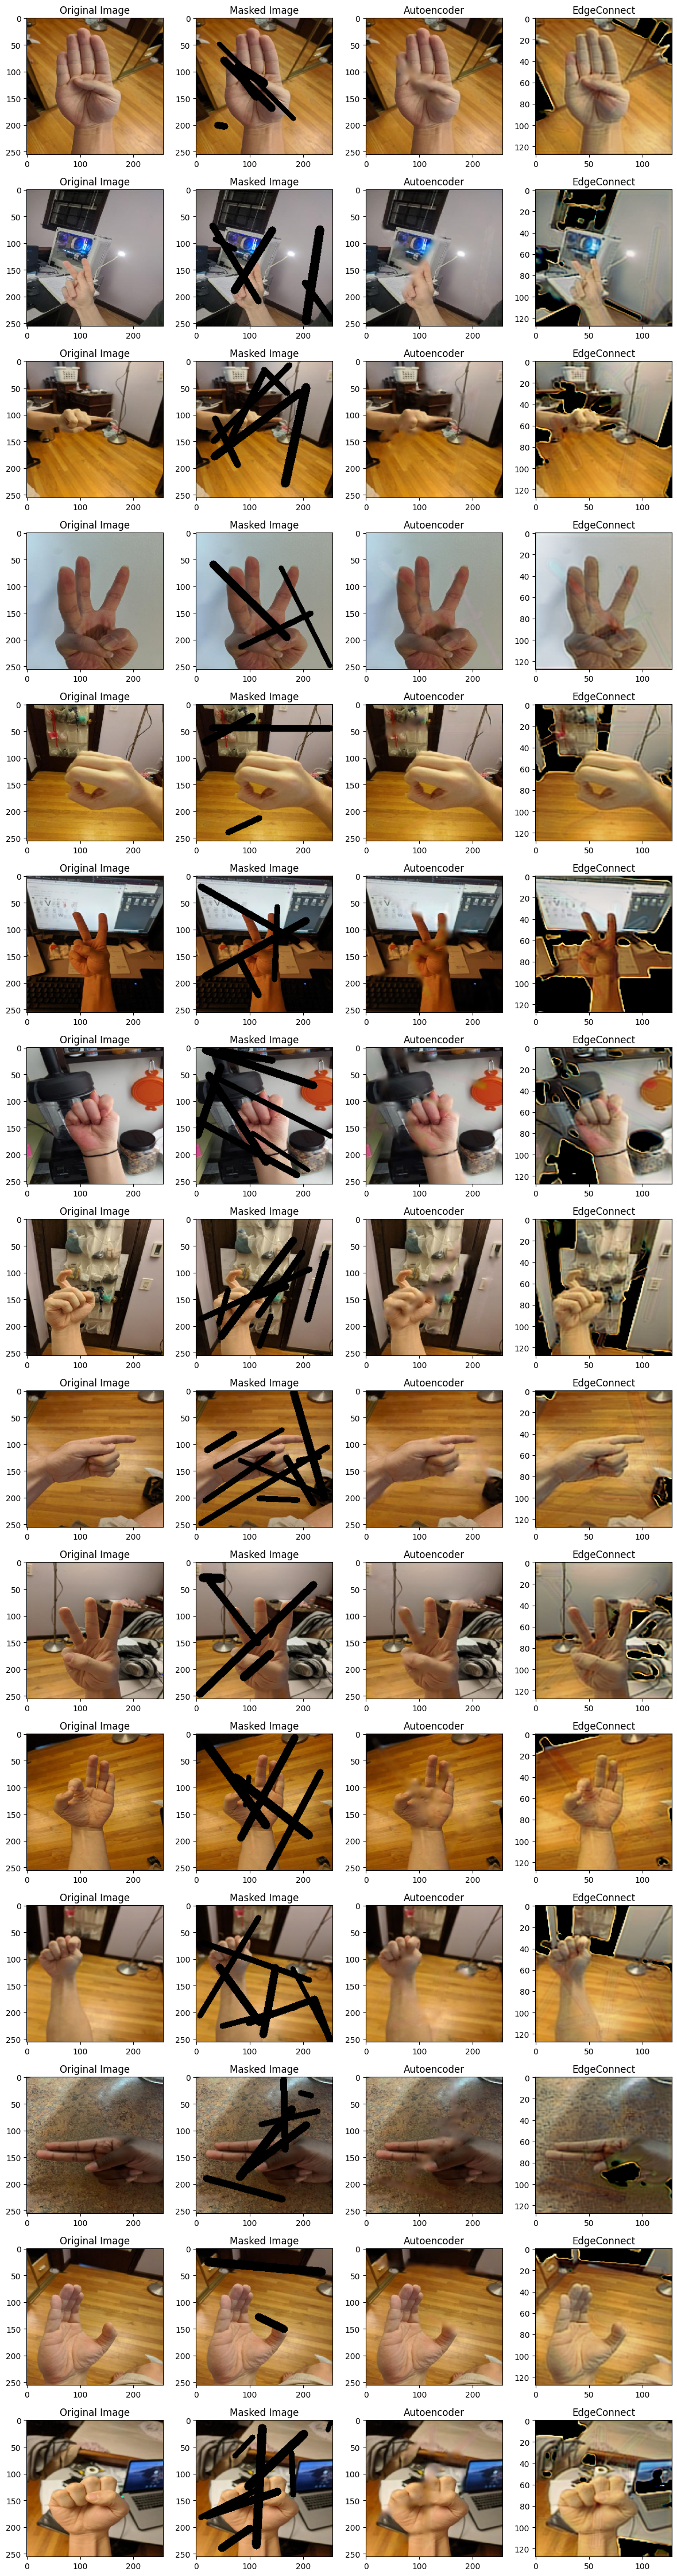

In [12]:
rows = 15
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(12, 3 * rows))

model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images and masks to tensors
    transforms.Resize((256, 256)),  # Resize images and masks to the target size
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  # Apply min-max normalization
])

with torch.no_grad():
    for i in range(rows):
        #mask image
        masked_image, mask = mask_image(x_test[i])
        
        # Autoencoder predict
        inpainted_image_keras = AE_model.predict(masked_image.reshape((1,) + masked_image.shape))

        # EdgeConnect predict
        img_torch = x_test[i]
        mask = cv2.resize(mask, (256, 256))
        mask = Image.fromarray(mask).convert("L")
        img_tensor = transform(img_torch).unsqueeze(0)
        mask_tensor = transform(mask).unsqueeze(0)
        img_with_mask = torch.cat((img_tensor, mask_tensor), dim=1)
        img_with_mask = img_with_mask.to(device)
        _, completion_torch = model(img_with_mask)
        completion_torch = completion_torch.cpu().numpy().transpose(0, 2, 3, 1)

        # Plot the images
        axs[i][0].imshow(x_test[i])
        axs[i][0].set_title('Original Image')

        axs[i][1].imshow(masked_image)
        axs[i][1].set_title('Masked Image')

        axs[i][2].imshow(inpainted_image_keras.reshape(inpainted_image_keras.shape[1:]))
        axs[i][2].set_title('Autoencoder')

        axs[i][3].imshow(completion_torch[0])
        axs[i][3].set_title('EdgeConnect')

    plt.tight_layout()
    plt.show()


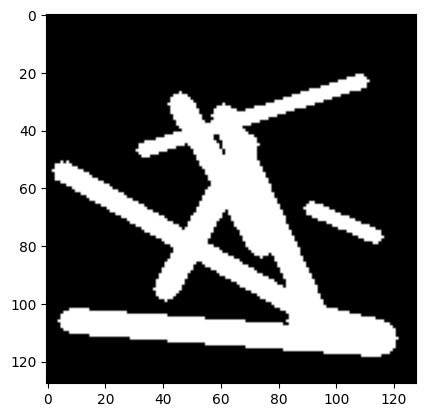

In [124]:
img = x_test[0]
m, mask = mask_image(img)
plt.imshow(mask)